# Behavioral Cloning

Other things to do:  

1. Collect more data by going round Track 1 counter clockwise.   
2. Collect more data by going on Track 2.  
3. Possibly try using throttle data ....
4. 

In [21]:
# basic
import numpy as np
import cv2

import csv

# data visualization
import matplotlib.pyplot as plt

## Load data

In [2]:
# set data location for local machine
data_loc = '/media/fqaiser94/ff3daf1f-fc36-43a4-a218-478126941f2a/behavioral-data/'

# set data location for AWS
#data_loc = '/behavioral-data/'

read images and angles into memory

In [15]:
lines = []

with open(data_loc + 'driving_log.csv') as csv_file: 
    
    reader = csv.reader(csv_file)
    
    for line in reader: 
        
        lines.append(line)    

# remove header row
lines = lines[1:]

In [20]:
images = []
angles = []
            
correction = 0.2

for line in lines:
    
    # there are 3 images in each row
    # each corresponding to the center, left and right cameras respectively
    for i in range(3): 
                    
        # get image in column j of row line 
        source_path = line[i]
        filename = source_path.split('/')[-1]
        path = data_loc + 'IMG/' + filename
        image = cv2.imread(path)

        # get angle associated with image in column j of row line 
        # add correction to angle based on the camera from which image came from
        angle = float(line[3])
        
        if i==0:
            angle = angle
        elif i==1:
            angle = angle + correction
        elif i==2:
            angle = angle - correction
        
        # add image/angle to list
        images.append(image)
        angles.append(angle)

Preprocess data

Perform some image flipping for better generalization.  

In [7]:
# image_flipped = np.fliplr(image)
# measurement_flipped = -measurement

histogram of angles

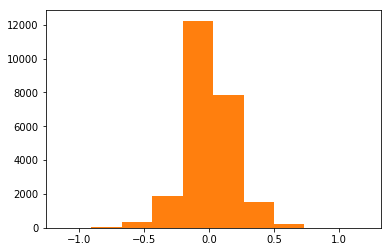

In [23]:
plt.hist(angles)
plt.show()

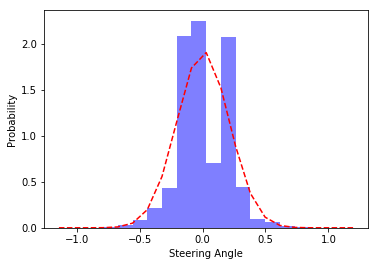

In [32]:
import matplotlib.mlab as mlab

num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(angles, num_bins, normed=1, facecolor='blue', alpha=0.5)
 
# add a 'best fit' line
mu = np.mean(angles)
sigma = np.std(angles)
y = mlab.normpdf(bins, mu, sigma)


plt.plot(bins, y, 'r--')
plt.xlabel('Steering Angle')
plt.ylabel('Probability')
# plt.title('Histogram of steering angles')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

Vast majority of steering angles are focused in the middle.  
This will bias our car toward steering down the middle.  

Generator function for loading batches of data into memory.  

In [3]:
from sklearn.model_selection import train_test_split

samples = []

with open(data_loc + 'driving_log.csv') as csv_file: 
    
    reader = csv.reader(csv_file)
    
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [4]:
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    
    num_samples = len(samples)
    
    while 1: 
        # Loop forever so the generator never terminates
        
        shuffle(samples)
        
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            correction = 0.2
            
            for batch_sample in batch_samples:
                
                for i in range(3): 
                    # this is to get center, left and right images

                    path = data_loc + 'IMG/' + batch_sample[i].split('/')[-1]
                    image = cv2.imread(path)
                    
                    angle = float(batch_sample[3])
                    
                    # add correction to angle based on image
                    if i==1:
                        angle = angle + correction
                    
                    elif i==2:
                        angle = angle - correction                    
                    
                    # add image and associated angle to list
                    images.append(image)
                    angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

# Basic model 

In [12]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D


# generate
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

# init
model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, 
                 input_shape=(160,320,3),
                 output_shape=(160,320,3)
                )
         )

# crop images to reduce noise, returns img of shape (80,320,3)
model.add(Cropping2D(cropping=((50,20), (0,0))))

# flatten
model.add(Flatten())

# fully-connected
model.add(Dense(1))

# compile
model.compile(loss='mse', optimizer='adam')

# fit  
history_object = model.fit_generator(generator = train_generator, 
                                     samples_per_epoch = len(train_samples), 
                                     validation_data = validation_generator,
                                     nb_val_samples = len(validation_samples), 
                                     nb_epoch=5, 
                                     verbose=1
                                    )

# save model

/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., validation_steps=1608, steps_per_epoch=6429, validation_data=<generator..., verbose=1, epochs=5)`


Epoch 1/5
   8/6429 [..............................] - ETA: 24:46 - loss: 6.3666

KeyboardInterrupt: 

Visualize our loss

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Advanced model 

Our model will be based on an architecture previously developed at NVIDIA.  

![NVIDIA Self Driving Car Architecture](https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture-624x890.png)

For more information, see the following [link](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/). 

In [13]:
def nVidiaModel():
    """
    Creates nVidea Autonomous Car Group model
    """
    
    # init
    model = Sequential()

    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

    # crop images to reduce noise, returns img of shape (80,320,3)
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    
    return model

In [14]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D

# generate
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

# generate model
model = nVidiaModel()

# compile
model.compile(loss='mse', optimizer='adam')

# fit  
history_object = model.fit_generator(generator = train_generator, 
                                     samples_per_epoch = len(train_samples), 
                                     validation_data = validation_generator,
                                     nb_val_samples = len(validation_samples), 
                                     nb_epoch=5, 
                                     verbose=1
                                    )

# save model

/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  from ipykernel import kernelapp as app
/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  app.launch_new_instance()
/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/ho

Epoch 1/5
   7/6429 [..............................] - ETA: 2:02:47 - loss: 0.0866

KeyboardInterrupt: 

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()